In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
rider = pd.read_csv('AmtrakBig_CA_Question-3.csv',
                    parse_dates=['Month'], 
                    index_col='Month',
                    date_parser=dateparse)
rider.head()

,Ridership,t,Season
Month,,,
2005-01-01,1709,1,Jan
2005-02-01,1621,2,Feb
2005-03-01,1973,3,Mar
2005-04-01,1812,4,Apr
2005-05-01,1975,5,May


In [3]:
cols = ['t','Season']
rider_ts = rider.drop(cols, axis = 1)
rider_ts.head()

,Ridership
Month,
2005-01-01,1709
2005-02-01,1621
2005-03-01,1973
2005-04-01,1812
2005-05-01,1975


In [4]:
len(rider_ts)

159

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


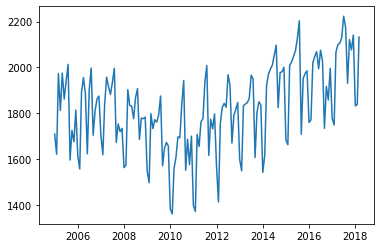

In [5]:
plt.plot(rider_ts)

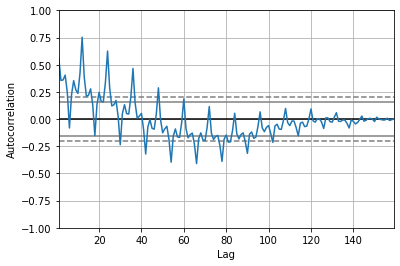

<Figure size 7200x3600 with 0 Axes>

In [6]:
autocorrelation_plot(rider_ts)
plt.figure(figsize=(100,50))
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    timeseries = timeseries.iloc[:,0].values
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

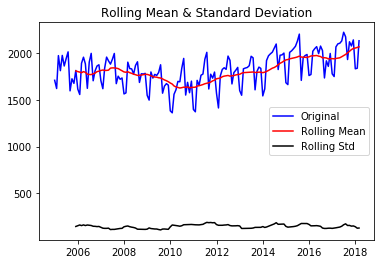

Results of Dickey-Fuller Test:
Test Statistic                  -0.234991
p-value                          0.934220
#Lags Used                      14.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [8]:
test_stationarity(rider_ts)

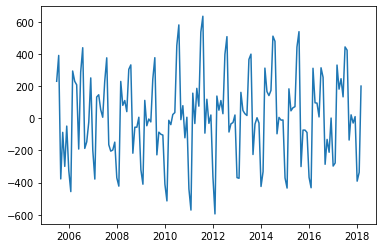

In [9]:
# Differencing 1
# lag 6
rider_diff_1 = rider_ts - rider_ts.shift(6)
plt.plot(rider_diff_1)

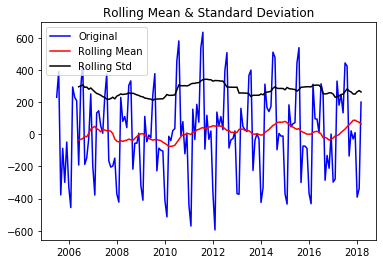

Results of Dickey-Fuller Test:
Test Statistic                  -4.031733
p-value                          0.001253
#Lags Used                       7.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64


In [10]:
test_stationarity(rider_diff_1.dropna())

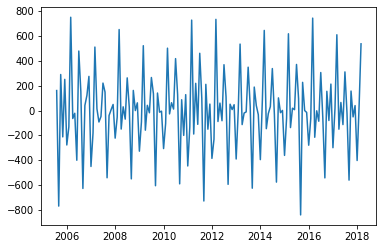

In [11]:
# Differencing 2
# lag 6
rider_diff = rider_ts - rider_ts.shift()
rider_diff_2 = rider_diff - rider_diff.shift(6)
plt.plot(rider_diff_2)

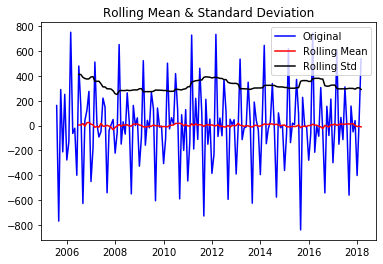

Results of Dickey-Fuller Test:
Test Statistic                -1.436878e+01
p-value                        9.572239e-27
#Lags Used                     6.000000e+00
Number of Observations Used    1.450000e+02
Critical Value (1%)           -3.476273e+00
Critical Value (5%)           -2.881688e+00
Critical Value (10%)          -2.577513e+00
dtype: float64


In [12]:
test_stationarity(rider_diff_2.dropna())

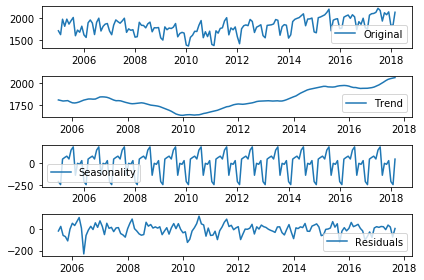

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(rider_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(rider_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

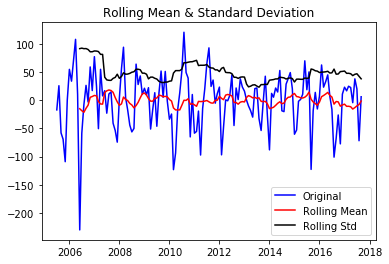

Results of Dickey-Fuller Test:
Test Statistic                -6.649005e+00
p-value                        5.177733e-09
#Lags Used                     9.000000e+00
Number of Observations Used    1.370000e+02
Critical Value (1%)           -3.479007e+00
Critical Value (5%)           -2.882878e+00
Critical Value (10%)          -2.578149e+00
dtype: float64


In [14]:
# check stationarity of residuals
rider_decompose = residual
rider_decompose.dropna(inplace=True)
test_stationarity(rider_decompose)

In [15]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(rider_diff_1.dropna(), nlags=150)
lag_pacf = pacf(rider_diff_1.dropna(), nlags=150, method='ols')

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


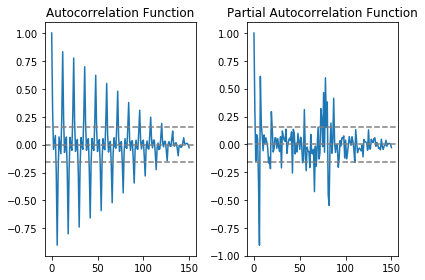

In [16]:
# Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rider_diff_1.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rider_diff_1.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rider_diff_1.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rider_diff_1.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

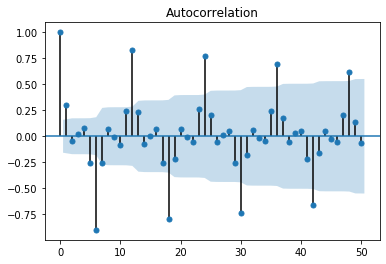

//anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


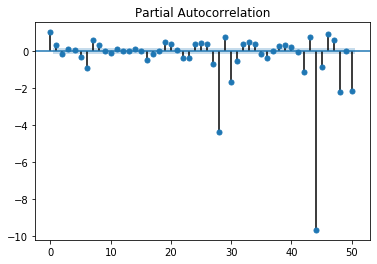

In [17]:
# d = 1
# ACF
plot_acf(rider_diff_1.dropna(), lags=50)
plt.show()

# PACF
plot_pacf(rider_diff_1.dropna(), lags=50)
plt.show()

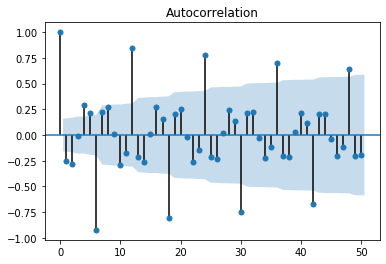

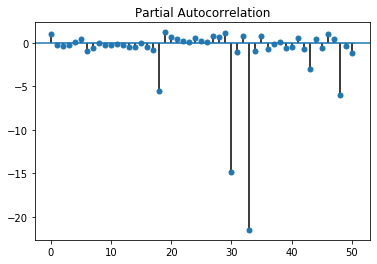

In [18]:
# d = 2
# ACF
plot_acf(rider_diff_2.dropna(), lags=50)
plt.show()

# PACF
plot_pacf(rider_diff_2.dropna(), lags=50)
plt.show()

In [16]:
# 1,1,1 ARIMA Model
model111 = ARIMA(rider_ts, order=(1,1,1))
model_fit111 = model111.fit(disp=0)
print(model_fit111.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Ridership   No. Observations:                  158
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1009.391
Method:                       css-mle   S.D. of innovations            143.387
Date:                Fri, 13 Sep 2019   AIC                           2026.782
Time:                        23:07:03   BIC                           2039.033
Sample:                    02-01-2005   HQIC                          2031.758
                         - 03-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.5669      1.425      1.100      0.273      -1.225       4.359
ar.L1.D.Ridership     0.3517      0.083      4.227      0.000       0.189       0.515
ma.L1.D.Ridership    -0.

In [17]:
# 1,2,1 ARIMA Model
model121 = ARIMA(rider_ts, order=(1,2,1))
model_fit121 = model121.fit(disp=0)
print(model_fit121.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.Ridership   No. Observations:                  157
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1025.396
Method:                       css-mle   S.D. of innovations            163.118
Date:                Fri, 13 Sep 2019   AIC                           2058.793
Time:                        23:07:07   BIC                           2071.018
Sample:                    03-01-2005   HQIC                          2063.758
                         - 03-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0291      0.228      0.128      0.898      -0.417       0.475
ar.L1.D2.Ridership    -0.2552      0.078     -3.282      0.001      -0.408      -0.103
ma.L1.D2.Ridership  

In [18]:
# 2,2,1 ARIMA Model
model221 = ARIMA(rider_ts, order=(2,2,1))
model_fit221 = model221.fit(disp=0)
print(model_fit221.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.Ridership   No. Observations:                  157
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1016.823
Method:                       css-mle   S.D. of innovations            154.059
Date:                Fri, 13 Sep 2019   AIC                           2043.646
Time:                        23:07:08   BIC                           2058.927
Sample:                    03-01-2005   HQIC                          2049.852
                         - 03-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0275      0.163      0.169      0.866      -0.292       0.347
ar.L1.D2.Ridership    -0.3410      0.076     -4.479      0.000      -0.490      -0.192
ar.L2.D2.Ridership  

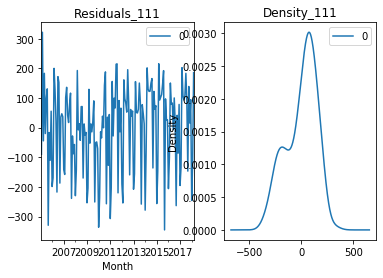

In [19]:
# Plot residual errors - Model111
residuals111 = pd.DataFrame(model_fit111.resid)
fig, ax = plt.subplots(1,2)
residuals111.plot(title="Residuals_111", ax=ax[0])
residuals111.plot(kind='kde', title='Density_111', ax=ax[1])
plt.show()

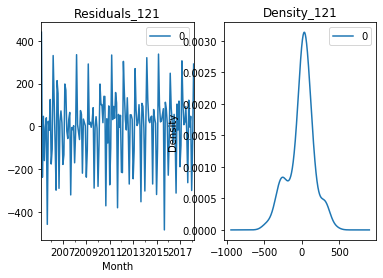

In [20]:
# Plot residual errors - Model121
residuals121 = pd.DataFrame(model_fit121.resid)
fig, ax = plt.subplots(1,2)
residuals121.plot(title="Residuals_121", ax=ax[0])
residuals121.plot(kind='kde', title='Density_121', ax=ax[1])
plt.show()

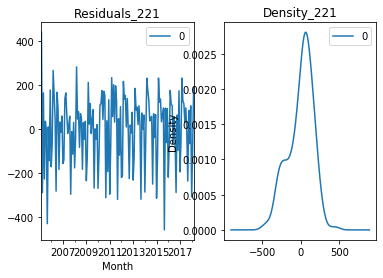

In [21]:
# Plot residual errors - Model221
residuals221 = pd.DataFrame(model_fit221.resid)
fig, ax = plt.subplots(1,2)
residuals221.plot(title="Residuals_221", ax=ax[0])
residuals221.plot(kind='kde', title='Density_221', ax=ax[1])
plt.show()

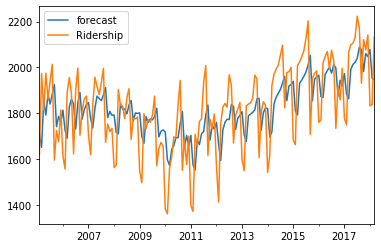

In [22]:
# Actual vs Fitted
model_fit111.plot_predict(dynamic=False)
plt.show()

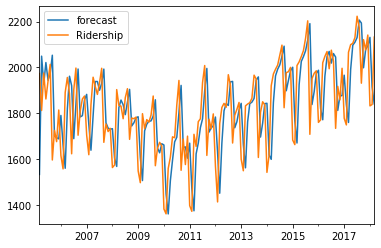

In [23]:
model_fit121.plot_predict(dynamic=False)
plt.show()

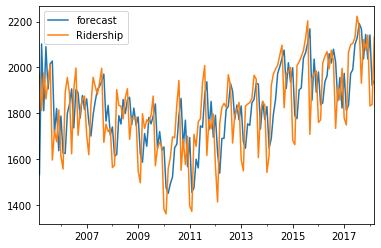

In [24]:
model_fit221.plot_predict(dynamic=False)
plt.show()

In [20]:
train = rider_ts[:132]
test = rider_ts[132:]

In [21]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'MAPE':mape, 'ME':me, 'MAE': mae, 
            'MPE': mpe, 'RMSE':rmse})

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Ridership   No. Observations:                  131
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -838.048
Method:                       css-mle   S.D. of innovations            144.568
Date:                Fri, 13 Sep 2019   AIC                           1684.096
Time:                        23:07:32   BIC                           1695.596
Sample:                    02-01-2005   HQIC                          1688.769
                         - 12-01-2015                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3076      1.734      0.754      0.452      -2.092       4.707
ar.L1.D.Ridership     0.3489      0.093      3.769      0.000       0.167       0.530
ma.L1.D.Ridership    -0.

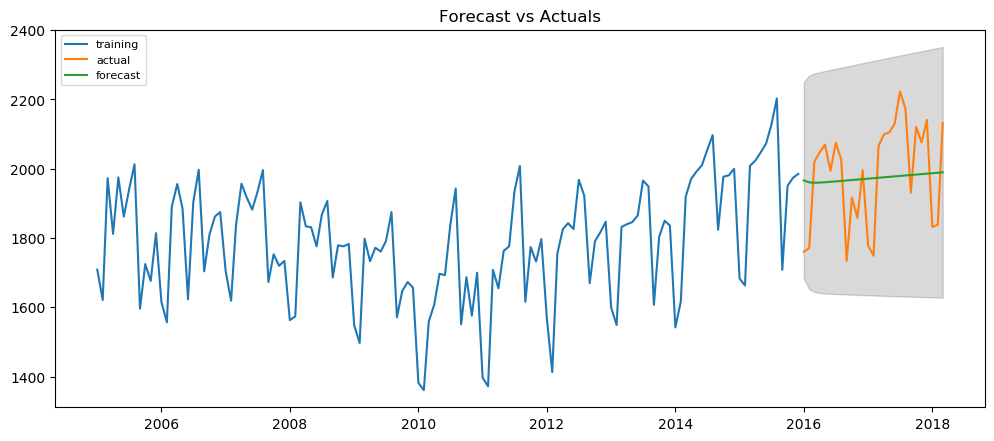

{'MAPE': 0.06652166376656933,
 'ME': -14.251096888558559,
 'MAE': 130.18032553077856,
 'MPE': -0.0016616030231503126,
 'RMSE': 146.1521416424199}

In [27]:
# 1,1,1 ARIMA Model
model_train = ARIMA(train, order=(1, 1, 1))  
fitted = model_train.fit(disp=-1)  
print(fitted.summary())

fc, se, conf = fitted.forecast(27, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.Ridership   No. Observations:                  130
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -850.219
Method:                       css-mle   S.D. of innovations            164.101
Date:                Fri, 13 Sep 2019   AIC                           1708.438
Time:                        23:07:37   BIC                           1719.909
Sample:                    03-01-2005   HQIC                          1713.099
                         - 12-01-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0345      0.303      0.114      0.910      -0.559       0.628
ar.L1.D2.Ridership    -0.2569      0.085     -3.040      0.003      -0.423      -0.091
ma.L1.D2.Ridership  

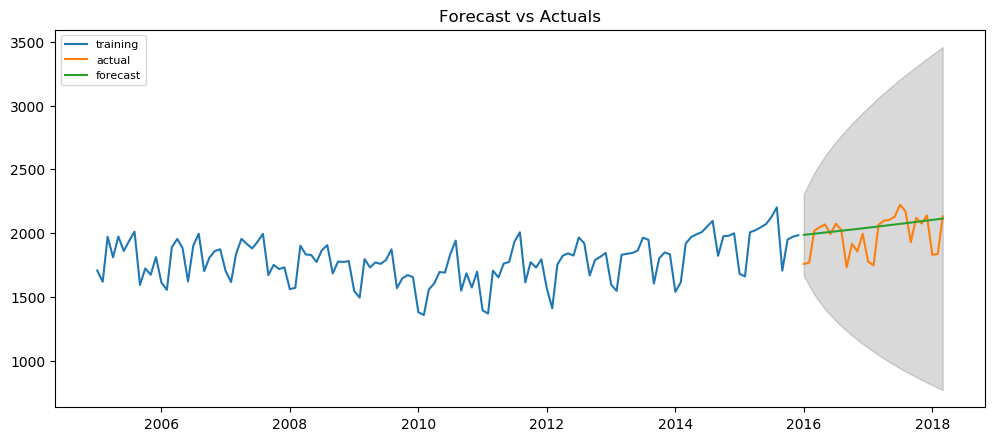

{'MAPE': 0.0673250674923668,
 'ME': 62.46606048650757,
 'MAE': 127.03420203102752,
 'MPE': 0.03715130472560223,
 'RMSE': 162.58720313096825}

In [28]:
# 1,2,1 ARIMA Model
model_train = ARIMA(train, order=(1, 2, 1))  
fitted = model_train.fit(disp=-1)  
print(fitted.summary())
fc, se, conf = fitted.forecast(27, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.Ridership   No. Observations:                  130
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -843.391
Method:                       css-mle   S.D. of innovations            155.240
Date:                Fri, 13 Sep 2019   AIC                           1696.781
Time:                        23:07:39   BIC                           1711.119
Sample:                    03-01-2005   HQIC                          1702.607
                         - 12-01-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0509      0.219      0.232      0.817      -0.378       0.480
ar.L1.D2.Ridership    -0.3412      0.083     -4.113      0.000      -0.504      -0.179
ar.L2.D2.Ridership  

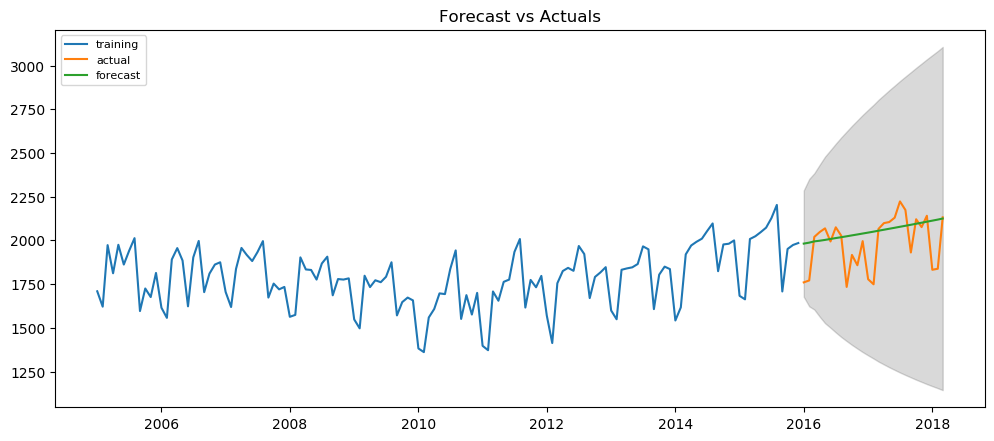

{'MAPE': 0.06802104122242708,
 'ME': 64.05042658971021,
 'MAE': 128.36548042250385,
 'MPE': 0.037952870600928064,
 'RMSE': 164.25998542566424}

In [29]:
# 2,2,1 ARIMA Model
model_train = ARIMA(train, order=(2, 2, 1))  
fitted = model_train.fit(disp=-1) 
print(fitted.summary())
fc, se, conf = fitted.forecast(27, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

Fit ARIMA: order=(1, 1, 1); AIC=1684.096, BIC=1695.596, Fit time=0.131 seconds
Fit ARIMA: order=(0, 1, 0); AIC=1720.563, BIC=1726.313, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1713.153, BIC=1721.778, Fit time=0.174 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1695.941, BIC=1704.566, Fit time=0.045 seconds
Fit ARIMA: order=(2, 1, 1); AIC=1684.934, BIC=1699.310, Fit time=0.139 seconds
Fit ARIMA: order=(1, 1, 2); AIC=1685.409, BIC=1699.785, Fit time=0.136 seconds
Fit ARIMA: order=(2, 1, 2); AIC=1658.796, BIC=1676.048, Fit time=0.390 seconds
Fit ARIMA: order=(3, 1, 2); AIC=1633.317, BIC=1653.443, Fit time=1.033 seconds
Fit ARIMA: order=(3, 1, 1); AIC=1695.135, BIC=1712.386, Fit time=0.243 seconds
Fit ARIMA: order=(3, 1, 3); AIC=1637.876, BIC=1660.878, Fit time=1.604 seconds
Total fit time: 3.916 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  131
Model:                

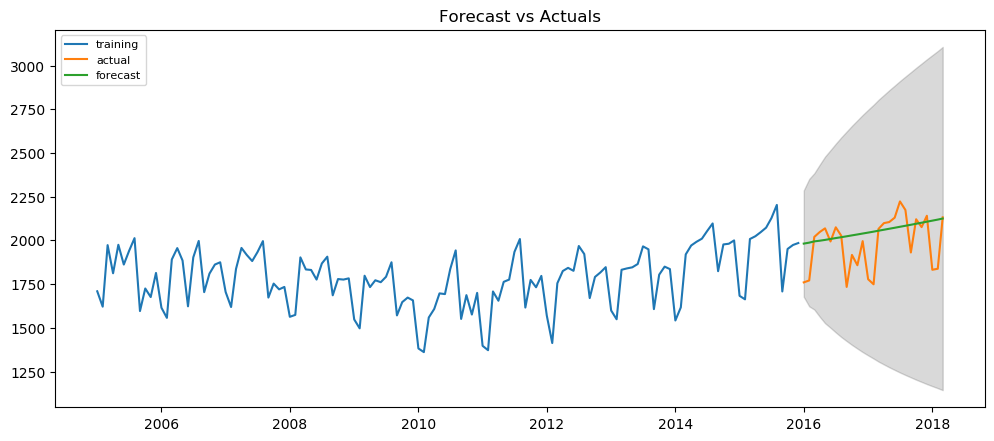

{'MAPE': 0.06802104122242708,
 'ME': 64.05042658971021,
 'MAE': 128.36548042250385,
 'MPE': 0.037952870600928064,
 'RMSE': 164.25998542566424}

In [30]:
# AUTO ARIMA
# d = 1
model_auto = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,          
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_auto.summary())

fc, se, conf = fitted.forecast(27, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

Fit ARIMA: order=(1, 2, 1); AIC=1708.438, BIC=1719.909, Fit time=0.269 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1828.903, BIC=1834.638, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1791.046, BIC=1799.649, Fit time=0.052 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1715.319, BIC=1723.922, Fit time=0.099 seconds
Fit ARIMA: order=(2, 2, 1); AIC=1696.781, BIC=1711.119, Fit time=0.131 seconds
Fit ARIMA: order=(2, 2, 0); AIC=1766.235, BIC=1777.705, Fit time=0.117 seconds
Fit ARIMA: order=(2, 2, 2); AIC=1678.868, BIC=1696.073, Fit time=0.525 seconds
Fit ARIMA: order=(3, 2, 3); AIC=1635.870, BIC=1658.811, Fit time=1.265 seconds
Fit ARIMA: order=(2, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 2, 2); AIC=1691.546, BIC=1711.619, Fit time=0.475 seconds
Total fit time: 2.958 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  130
Model:                 ARIMA(3, 2,

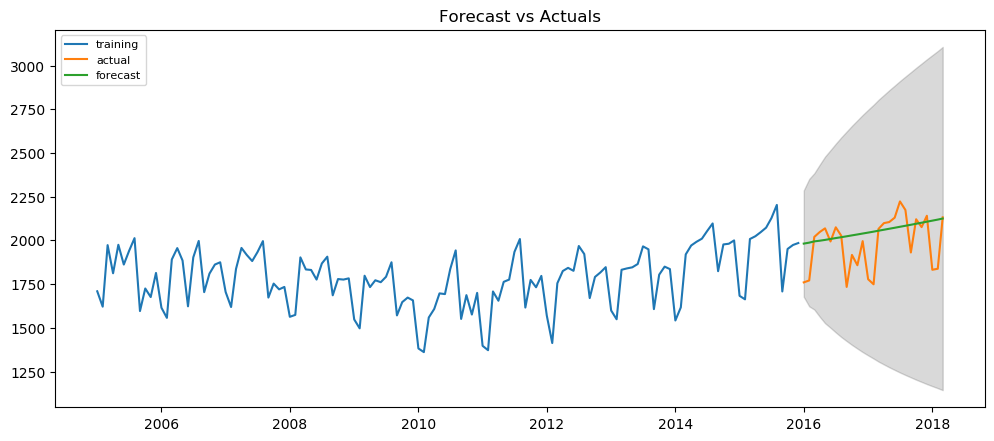

{'MAPE': 0.06802104122242708,
 'ME': 64.05042658971021,
 'MAE': 128.36548042250385,
 'MPE': 0.037952870600928064,
 'RMSE': 164.25998542566424}

In [31]:
# AUTO ARIMA
# d = 2
model_auto = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,          
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_auto.summary())

fc, se, conf = fitted.forecast(27, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

forecast_accuracy(fc, test.values)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=1624.238, BIC=1638.379, Fit time=0.658 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=1797.234, BIC=1802.891, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=1467.465, BIC=1478.778, Fit time=0.390 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=1636.671, BIC=1647.984, Fit time=0.387 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=1791.056, BIC=1799.541, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 6); AIC=1553.683, BIC=1567.824, Fit time=0.304 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 6); AIC=1463.096, BIC=1477.238, Fit time=0.524 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 2, 6); AIC=1533.218, BIC=1553.016, Fit time=0.960 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 6); AIC=1477.118, BIC=1488.431, Fit time=0.472 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

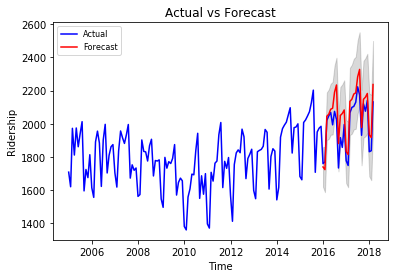

NameError: name 'fc' is not defined

In [22]:
# Seasonal - fit stepwise auto-ARIMA
# d = 1
smodel = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=6,             # frequency of series
                      d=1,          
                      seasonal=True,  
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(smodel.summary())

# Forecast
n_periods = 27
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(rider_ts, color='blue', label='Actual')
plt.plot(fitted_series, color='red', label = 'Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()

forecast_accuracy(fc, test.values)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1343.950, BIC=1357.804, Fit time=0.477 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1498.665, BIC=1504.207, Fit time=0.022 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1427.098, BIC=1438.181, Fit time=0.717 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1356.783, BIC=1367.866, Fit time=0.383 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=1345.812, BIC=1362.437, Fit time=0.706 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1375.917, BIC=1387.000, Fit time=0.158 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=1345.807, BIC=1362.432, Fit time=1.602 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=1347.267, BIC=1366.661, Fit time=3.390 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1343.197, BIC=1359.821, Fit time=0.804 seconds
Fit ARIMA: order=(2, 2, 0) s

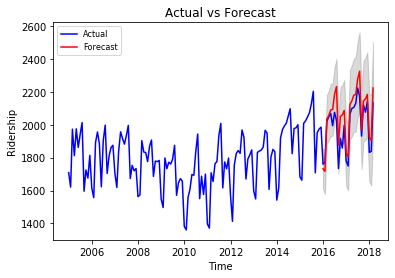

{'MAPE': 0.06802104122242708,
 'ME': 64.05042658971021,
 'MAE': 128.36548042250385,
 'MPE': 0.037952870600928064,
 'RMSE': 164.25998542566424}

In [33]:
# Seasonal - fit stepwise auto-ARIMA
# d = 2
model_auto = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,          
                      seasonal=True,  
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_auto.summary())

# Forecast
n_periods = 27
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(rider_ts, color='blue', label='Actual')
plt.plot(fitted_series, color='red', label = 'Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()

forecast_accuracy(fc, test.values)

In [34]:
# Fitting ARIMA: d = 1
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2295      0.174      1.316      0.188      -0.112       0.571
ma.L1         -0.6781      0.136     -4.972      0.000      -0.945      -0.411
ma.S.L12      -0.6352      0.098     -6.471      0.000      -0.828      -0.443
sigma2      3229.8285    462.029      6.991      0.000    2324.269    4135.388


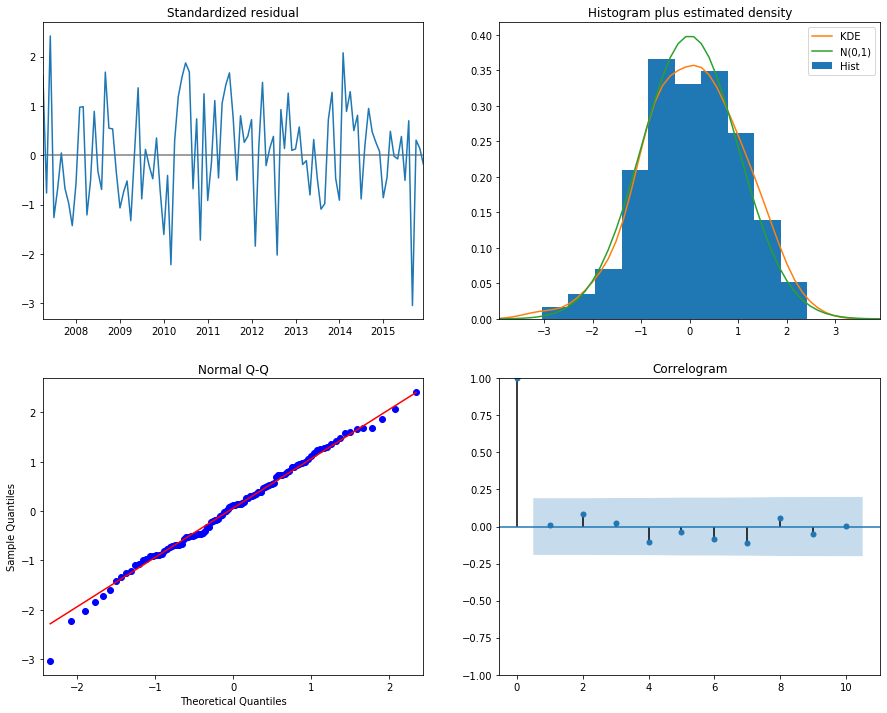

In [35]:
# residual plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [36]:
# Fitting ARIMA: d = 2
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 2, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3885      0.116     -3.364      0.001      -0.615      -0.162
ar.L2         -0.0951      0.096     -0.986      0.324      -0.284       0.094
ma.L1         -1.0000    434.943     -0.002      0.998    -853.473     851.473
ma.S.L12      -0.6280      0.105     -6.009      0.000      -0.833      -0.423
sigma2      3269.2320   1.42e+06      0.002      0.998   -2.78e+06    2.79e+06


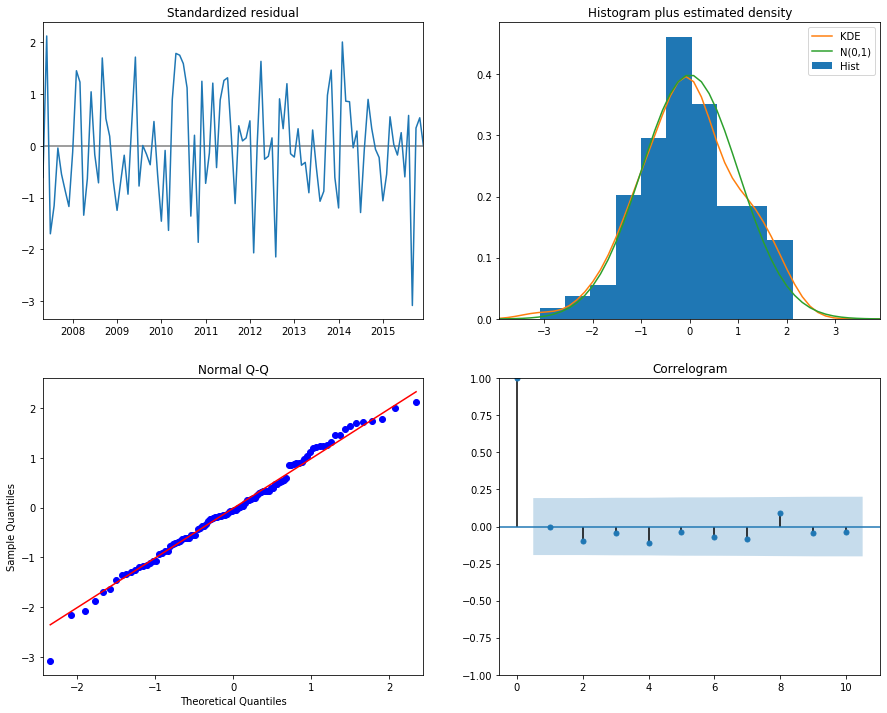

In [37]:
# residual plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1627.802, BIC=1642.720, Fit time=1.585 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1701.905, BIC=1707.873, Fit time=0.053 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1656.951, BIC=1668.885, Fit time=0.577 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1629.323, BIC=1641.258, Fit time=0.642 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1629.360, BIC=1647.261, Fit time=1.164 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1678.181, BIC=1690.115, Fit time=0.367 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1629.290, BIC=1647.191, Fit time=2.568 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1631.612, BIC=1652.497, Fit time=5.805 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1628.066, BIC=1645.968, Fit time=1.979 seconds
Fit ARIMA: order=(1, 1, 0) s

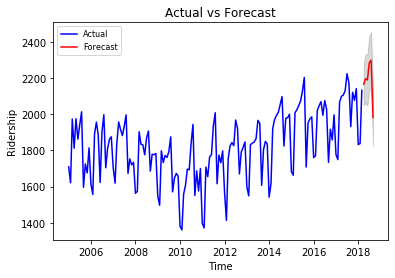

2018-04-01    2165.245581
2018-05-01    2196.078719
2018-06-01    2188.711302
2018-07-01    2284.030656
2018-08-01    2297.959018
2018-09-01    1982.158142
Freq: MS, dtype: float64


In [38]:
# Final Model
# d = 1
final_model = pm.auto_arima(rider_ts.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=1,          
                      seasonal=True,  
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(final_model.summary())

# Forecast
n_periods = 6
fitted, confint = final_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(rider_ts.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(rider_ts, color='blue', label='Actual')
plt.plot(fitted_series, color='red', label = 'Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()

print(fitted_series)

In [ ]:
# Final Model
# d = 2
final_model = pm.auto_arima(rider_ts.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,          
                      seasonal=True,  
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(final_model.summary())

# Forecast
n_periods = 6
fitted, confint = final_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(rider_ts.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(rider_ts, color='blue', label='Actual')
plt.plot(fitted_series, color='red', label = 'Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title("Actual vs Forecast")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.show()

print(fitted_series)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1633.950, BIC=1648.833, Fit time=1.564 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1834.841, BIC=1840.795, Fit time=0.032 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1742.773, BIC=1754.679, Fit time=0.602 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1648.923, BIC=1660.830, Fit time=1.754 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=1635.779, BIC=1653.640, Fit time=1.059 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1682.237, BIC=1694.144, Fit time=0.309 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=1635.758, BIC=1653.619, Fit time=2.678 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=1637.677, BIC=1658.514, Fit time=9.007 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1632.360, BIC=1650.221, Fit time=1.039 seconds
Fit ARIMA: order=(2, 2, 0) s